C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


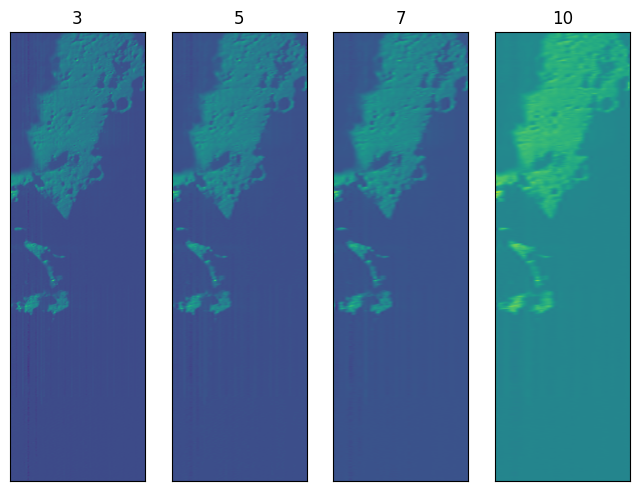

In [9]:
import numpy as np
import os
import pandas as pd
from HySpec_Image_Processing import HDR_Image
from fancy_spec_plot import fancy_spec_plot
import matplotlib.pyplot as plt
from spec_average import spec_avg
from scipy import interpolate as interp
import numpy.random as r
from scipy import signal
import spectral as sp
import tifffile as tf
from fancy_spec_plot import plot_numpy_images
from copy import copy

def destripe(image,box_size,**kwargs):
    defaultKwargs = {"plotImg":False}
    kwargs = {**defaultKwargs,**kwargs}

    destripedImage = np.zeros(image.shape)
    n=0
    for row in range(image.shape[0]):
        xCoords = np.arange(image.shape[1])
        yAvg,std,xAvg = spec_avg(image[row,:,0],xCoords,box_size)
        f = interp.CubicSpline(xAvg,yAvg)
        xtest = np.linspace(0,image.shape[1],304)
        destripedImage[row,:,0] = f(xtest)
        if kwargs.get('plotImg') == True:
            if n<3:
                fig,ax = plt.subplots(1,1)
                ax.plot(xCoords,image[row,:,0])
                ax.plot(xAvg,yAvg)
                ax.plot(xtest,f(xtest))
            else:
                pass
            fig,ax = plt.subplots(1,1)
            ax.imshow(destripedImage[:,:,0])

        n+=1
    
    sharp = np.array(([0,-1,0],[-1,10,-1],[0,-1,0]))
    destripedImage_sharp = signal.convolve2d(destripedImage[:,:,0],sharp)

    return destripedImage_sharp

hdr = sp.envi.open(r'D:\Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr')
bandCenters = hdr.bands.centers
bandCenters = np.array(bandCenters)

allowedIndices = np.where((bandCenters>900)&(bandCenters<2600))[0]
allowedWvl = bandCenters[allowedIndices]

image = hdr.read_bands(allowedIndices)

im1,im2,im3,im4 = destripe(image,3),destripe(image,5),destripe(image,7),destripe(image,10)

plot_numpy_images(im1,im2,im3,im4,titles=['3','5','7','10'],figtitle='Destriping Images')

In [52]:
import fancy_spec_plot

fancy_spec_plot.plot_numpy_images()

AttributeError: module 'fancy_spec_plot' has no attribute 'plot_numpy_images'

In [17]:
import scipy.sparse as sps
import numpy as np

arr1 = 2*np.ones((100,100))
arr2 = 3*np.ones((100,100))
bigarr = np.array((arr1,arr2))

x,y=np.where(bigarr==2)[0],np.where(bigarr==2)[1]




(10000,) (10000,)


C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Image 2009-04-17_19-33-20 Loaded:
Analyzed Wavelengths: [ 910.14  930.1   950.06  970.02  989.98 1009.95 1029.91 1049.87 1069.83
 1089.79 1109.76 1129.72 1149.68 1169.64 1189.6  1209.57 1229.53 1249.49
 1269.45 1289.41 1309.38 1329.34 1349.3  1369.26 1389.22 1409.19 1429.15
 1449.11 1469.07 1489.03 1508.99 1528.96 1548.92 1578.86 1618.79 1658.71
 1698.63 1738.56 1778.48 1818.4  1858.33 1898.25 1938.18 1978.1  2018.02
 2057.95 2097.87 2137.8  2177.72 2217.64 2257.57 2297.49 2337.42 2377.34
 2417.26 2457.19 2497.11 2537.03 2576.96]
Destriping Image...
Band 59 of 59 processed. (100%)

Image destriped at 112.1 seconds
Obtaining image and mosaic statistics...
.zip Files have already been extracted
Loading Images...
Images Loaded at 11.352874279022217 seconds
Getting list of shadow arrays...
2009-04-17_19-33-20_shadow.npy is already saved.
2009-05-15_04-30-23_shadow.npy is already saved.
2009-05-15_04-31-07_shadow.npy is already saved.
2009-06-05_16-32-32_shadow.npy is already saved.
2009-06

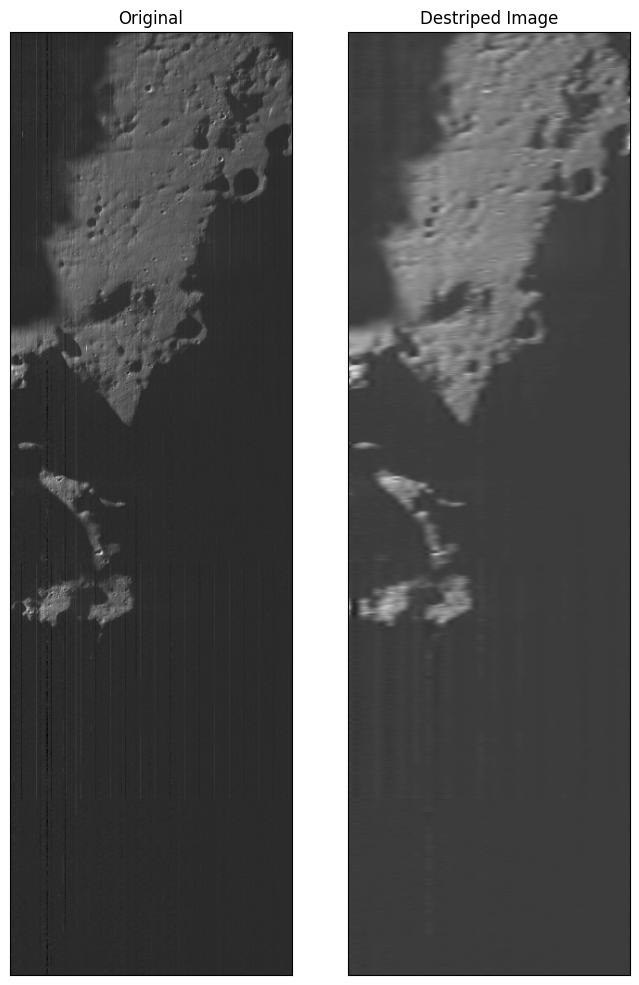

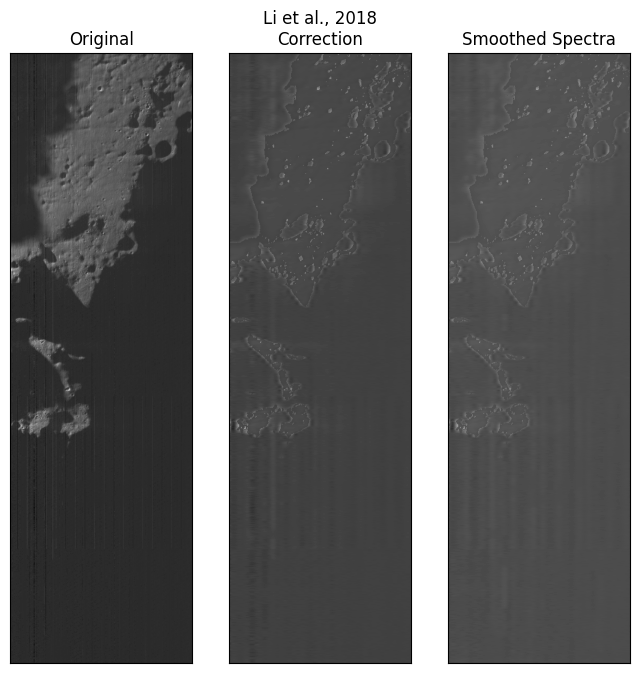

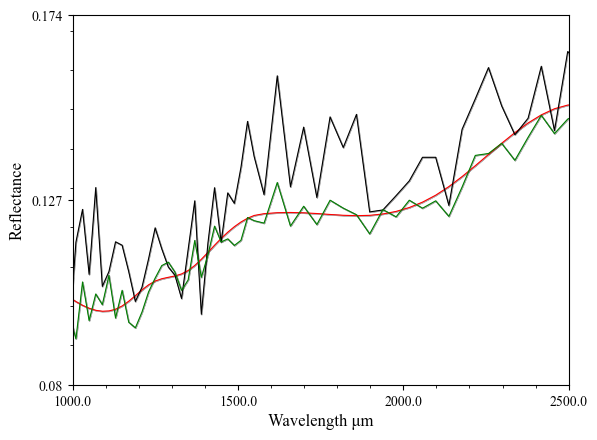

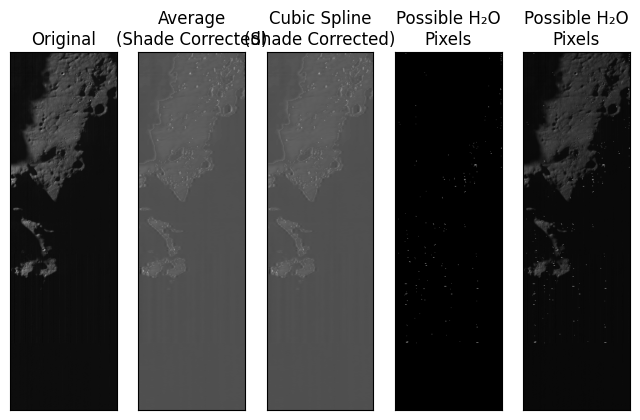

In [57]:
import importlib
import Locate_Ice as ice
importlib.reload(ice)
import time
import get_pixel_mosaic


img1 = ice.HDR_Image(r"D:\Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr")
start = time.time()
print (f'Image {img1.datetime} Loaded:\n\
Analyzed Wavelengths: {img1.allowedWavelengths}')
originalImage = img1.original_image()

print ('Destriping Image...')
destripeImage = img1.destripe_image(imshow=True)
print (f'Image destriped at {time.time()-start:.1f} seconds')

print ('Obtaining image and mosaic statistics...')
shadowDict,imageStats,mosaicPixels,mosaicStats = get_pixel_mosaic.create_arrays(r"D:/Data/20230209T095534013597/",r"D:/Data/Locate_Ice_Saves/")
print (f'Image and mosaic statistics obtained at {time.time()-start:.1f} seconds')

print ('Calculating Average Mosaic Reflectance...')
averageRfl,stdRfl = img1.get_average_rfl(mosaicPixels)
print (f'Average reflectance obtained at {time.time()-start:.1f} seconds')

print ('Making Li et al., 2018 Shadow Correction...')
correctedImage = img1.shadow_correction(averageRfl,shadowDict[img1.datetime])
print (f'Correction completed at {time.time()-start:.1f} seconds')

print('Smoothing spectra...')
avgSpecImg,smoothSpecImg = img1.spectrum_smoothing(imshow=True,specshow=True,plottedPoints = (91,100))
print (f'Smooth spectra obtained at {time.time()-start:.1f} seconds')

print('Locating water-like spectra...')
waterPixels_noise,waterPixels,waterDf=img1.locate_ice(imshow=True)
print (f'Water-like spectra located at {time.time()-start:.1f} seconds')

C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


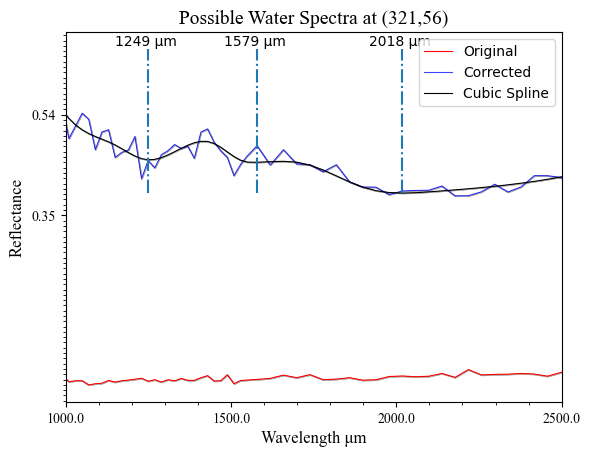

In [8]:
import spec_plotting
import importlib
importlib.reload(spec_plotting)
from spec_plotting import fancy_spec_plot
import pandas as pd
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import Locate_Ice
from Locate_Ice import HDR_Image

img1 = HDR_Image(r"D:\Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr")

waterDf = pd.read_csv(r"D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/water_locations.csv")
waterDf.columns = ['x','y','Band 1','Band 2','Band 3']
waterDf.set_index(['x','y'],inplace=True)

originalImage = np.load(r"D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/Original_Image.npy")
smoothSpectrumImage = np.load(r"D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/Smooth_Spectrum_Image.npy")
correctedImage = np.load(r"D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/Corrected_Image.npy")
waterImage = np.load(r"D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/Water_Locations.npy")

allowedWavelengths = img1.allowedWavelengths

def plot_correction_minima(x,y,**kwargs):
    defaultKwargs = {'showMinText':True,'showPlot':True}
    kwargs = {**defaultKwargs,**kwargs}

    fig,ax = plt.subplots(1,1)
    fancy_spec_plot(fig,ax,allowedWavelengths,originalImage[x,y,:],label='Original',line_color='red',
                                    ylabel='Reflectance',xlabel='Wavelength (\u03BCm)')
    fancy_spec_plot(fig,ax,allowedWavelengths,correctedImage[x,y,:],label='Corrected',line_color='blue',alpha=0.75)
    fancy_spec_plot(fig,ax,allowedWavelengths,smoothSpectrumImage[x,y,:],label='Cubic Spline',line_color='k',
                                    title=f'Possible Water Spectra at ({x},{y})')

    #print (waterDf)

    if (x,y) in waterDf.index:
        wvlMin = waterDf.loc[(x,y)]
        if kwargs.get('showMinText') == True:
            for val in wvlMin:
                ax.vlines(val,smoothSpectrumImage[x,y,:].min(),smoothSpectrumImage[x,y,:].max(),ls='-.')
                ax.text(val-100,smoothSpectrumImage[x,y,:].max()+0.01*smoothSpectrumImage[x,y,:].max(),f'{val:.0f} \u03BCm')

    ax.legend()

# for x,y in waterDf.index:
#     plot_correction_minima(int(x),int(y),showPlot=False)
#     plt.savefig(f'D:/Data/Locate_Ice_Saves/Water Spectra/({x},{y}).png')
#     plt.close()

plot_correction_minima(321,56)

#tf.imwrite(f"D:/Data/Water_Rasters/{img1.datetime} Ice Locations.tif",waterImage,photometric='rgb')

In [10]:
tf.imwrite("D:/Data/Locate_Ice_Saves/2009-04-17_19-33-20/original.tif",originalImage,photometric='rgb')

[241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420
 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 478 479]
Water Length: (480, 1), Wavelength Length: (480, 1)
fl

(1, 270)

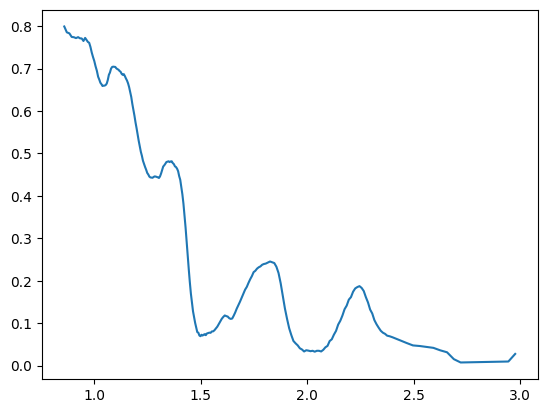

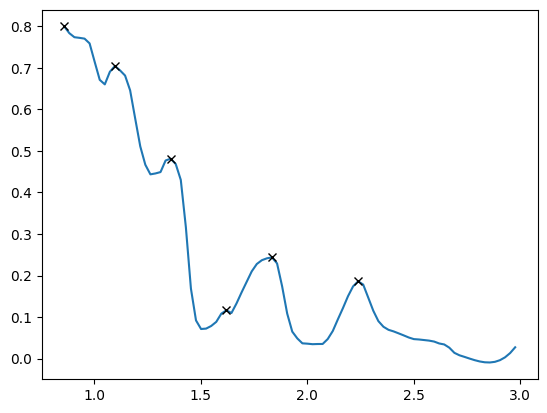

In [171]:
##Water Frost Spectrum
import scipy.interpolate as interp
water = pd.read_csv(r"D:/Data/USGS_Water_Ice/splib07a_H2O-Ice_GDS136_77K_BECKa_AREF.txt")
wavelengths = pd.read_csv(r"D:/Data/USGS_Water_Ice/splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt")
water.columns = ['']
wavelengths.columns = ['']

goodIndices = np.where(water>0)[0]
print (goodIndices)

wvl,rfl = wavelengths.iloc[goodIndices,0],water.iloc[goodIndices,0]
print (f'Water Length: {water.shape}, Wavelength Length: {wavelengths.shape}')
plt.plot(wvl,rfl)
f = interp.CubicSpline(wvl,rfl)
xtest = np.linspace(wvl.min(),wvl.max(),90)

fig,ax = plt.subplots(1,1)
ax.plot(xtest,f(xtest))
print (f(xtest).dtype)

diff_list = []
points = np.zeros((6,2))
pos = 0
for n in range(len(f(xtest))):
    #print (n)
    if n+1<len(f(xtest)):
        diff = f(xtest)[n]-f(xtest)[n-1]
        diff_list.append(diff)
    if diff<0 and diff_list[-2]>0:
        ax.plot(xtest[n-1],f(xtest)[n-1],marker='x',color='k')
        points[pos,:] = (xtest[n-1],f(xtest)[n-1])
        pos+=1

xfit,yfit = points[[0,1,2,4,5],0],points[[0,1,2,4,5],1]
print (xfit.shape)

z = np.polyfit(xfit, yfit, 2)

z = np.array([np.flip(z)])

powers = np.array([np.arange(0, len(z[0]))])

def poly(x, z):
    return np.dot(z, np.repeat(x, len(z[0]), axis=0)**powers.T)

f1 = poly(xtest, z)
f1.shape


#ax.plot(xtest,f1)

    




In [24]:
class Test_Class():
    def __init__(self,prop1,prop2):
        self._prop1 = prop1
        self._prop2 = prop2
    
    def print(self):
        self._test = 1
        print (self.prop1,self.prop2)

    @property
    def property1(self):
        return self._prop1
    
    @property1.setter
    def property1(self,value):
        
        self._prop1 = value.upper()
    
    @property
    def property2(self):
        return self._prop2
    
    def test(self):
        return self._test
    

obj = Test_Class('hi','world')
print (obj.test())

AttributeError: 'Test_Class' object has no attribute '_test'

In [46]:
import numpy as np
import Locate_Ice

obj = Locate_Ice.HDR_Image('E:/Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr')
print (obj.allWavelengths)
img = obj.hdr.read_bands(range(len(obj.allWavelengths)-2))
print(img.reshape(img.shape[0]*img.shape[1],83).T.shape)

arr = np.load('E:/Data/mosaic_pixels.npy')
print (arr.shape)

1017*304

C:\Users\zvig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


[ 460.99  500.92  540.84  580.76  620.69  660.61  700.54  730.48  750.44
  770.4   790.37  810.33  830.29  850.25  870.21  890.17  910.14  930.1
  950.06  970.02  989.98 1009.95 1029.91 1049.87 1069.83 1089.79 1109.76
 1129.72 1149.68 1169.64 1189.6  1209.57 1229.53 1249.49 1269.45 1289.41
 1309.38 1329.34 1349.3  1369.26 1389.22 1409.19 1429.15 1449.11 1469.07
 1489.03 1508.99 1528.96 1548.92 1578.86 1618.79 1658.71 1698.63 1738.56
 1778.48 1818.4  1858.33 1898.25 1938.18 1978.1  2018.02 2057.95 2097.87
 2137.8  2177.72 2217.64 2257.57 2297.49 2337.42 2377.34 2417.26 2457.19
 2497.11 2537.03 2576.96 2616.88 2656.81 2696.73 2736.65 2776.58 2816.5
 2856.43 2896.35 2936.27 2976.2 ]
(83, 309168)
(83, 4385631)


309168

In [69]:
import spectral as sp
import tifffile as tf
hdr = sp.envi.open(r"E:\Data\20230209T095534013597\extracted_files\hdr_files\m3g20090814t060013_v01_rfl\m3g20090814t060013_v01_rfl.hdr")

bandCenters = np.array(hdr.bands.centers)
wvlIndices = np.where((bandCenters>900)&(bandCenters<2600))[0]

originalImage = hdr.read_bands(wvlIndices)
tf.imwrite(f'E:/Data/Locate_Ice_Saves/2009-08-14_06-00-13/original.tif',originalImage,photometric='rgb')

Max:1.0,Min:0.0


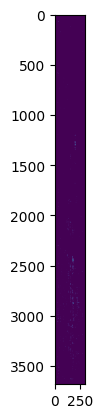

In [47]:
im = tf.imread(r"C:\Users\zvig\OneDrive - University of Iowa\Desktop\Lunar Images\Image Products\Water Locations\WaterLocations_2009-08-14_06-00-13.tif")
plt.imshow(im[:,:,0])
print(f'Max:{im[:,:,0].max()},Min:{im[:,:,0].min()}')

In [3]:
mydict = {'1':[1,1],'2':[2,2]}
mydict.update({'3':[3]*2})
if '3' in mydict.keys():
    print ('yes')
mydict.get('3').append(6)
print (mydict.get())


yes


TypeError: unhashable type: 'list'

In [44]:
from bs4 import BeautifulSoup
import lxml


working = tf.imread(r'C:/Users/zvig/OneDrive - University of Iowa/Desktop/water_locations.tif')
notWorking = tf.imread(r'C:/Users/zvig/OneDrive - University of Iowa/Desktop/Lunar Images/Image Products/Water Locations/WaterLocations_2009-04-17_19-33-20.tif')

print (working.dtype)
print (notWorking.dtype)


with open(r"C:\Users\zvig\OneDrive - University of Iowa\Desktop\original.tif.aux.xml") as f:
    data =f.read()

bs_data = BeautifulSoup(data,"xml")
bs_data.find_all('Double')

float64
float64


[<Double>-1.1460849342071526</Double>,
 <Double>1.1541141764048177</Double>,
 <Double>304.16249952733051</Double>,
 <Double>-1013.1219504927431</Double>,
 <Double>303.65634348571439</Double>,
 <Double>0.38022212808141376</Double>,
 <Double>-0.73390260302981858</Double>,
 <Double>-1016.446274398549</Double>,
 <Double>-0.93237423138654663</Double>,
 <Double>-995.80939735167613</Double>,
 <Double>-0.75593692860356043</Double>,
 <Double>-978.72282055610151</Double>,
 <Double>-0.53204292085934535</Double>,
 <Double>-912.66615040872887</Double>,
 <Double>-3.9377662201746575</Double>,
 <Double>-925.82190464165205</Double>,
 <Double>-0.81853501619304581</Double>,
 <Double>-969.2938188746939</Double>,
 <Double>-0.13227423073482214</Double>,
 <Double>-785.10857328278121</Double>,
 <Double>152.17216617144703</Double>,
 <Double>0.65900451278935179</Double>,
 <Double>132.23324474378995</Double>,
 <Double>0.64738967322955432</Double>,
 <Double>94.520778910089717</Double>,
 <Double>-561.1000731296817

In [9]:
mylist = [12,13,14,15,16,17,18]
mylist = [str(i) for i in mylist]

print (mylist[[i for i,s in enumerate(mylist) if '6' in s][0]])

16


In [20]:
import numpy as np
myarr = np.array((1,2,3,4,5))
print (np.where(myarr==[3,5])[0])

[]


C:\Users\zvig\AppData\Local\Temp\ipykernel_4756\3666689829.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print (np.where(myarr==[3,5])[0])


In [32]:
import tifffile as tf
walk = os.walk(r'E:\Data\Locate_Ice_Saves')
for root,dirs,files in walk:
    if root.find('2009')>-1:
        for file in files:
            if file.find('.tif')>-1:
                img = tf.imread(os.path.join(root,file))
                tf.imwrite(r'D:/Posters and Presentation/Supporting Images/'+file[0:len(file)-4]+root[-19:]+'_readable.tif',img[:,:,0])
                print (f'{root},{file} has been saved.')

E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20,original.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20,destriped.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20,corrected.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20,smoothed.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20,water_locations.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-30-23,original.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-30-23,destriped.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-30-23,corrected.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-30-23,smoothed.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-30-23,water_locations.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-31-07,original.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-31-07,destriped.tif has been saved.
E:\Data\Locate_Ice_Saves\2009-05-15_04-31-07,corrected.tif has been saved.
E:\Data\Locate_Ice

[ 910.14  930.1   950.06  970.02  989.98 1009.95 1029.91 1049.87 1069.83
 1089.79 1109.76 1129.72 1149.68 1169.64 1189.6  1209.57 1229.53 1249.49
 1269.45 1289.41 1309.38 1329.34 1349.3  1369.26 1389.22 1409.19 1429.15
 1449.11 1469.07 1489.03 1508.99 1528.96 1548.92 1578.86 1618.79 1658.71
 1698.63 1738.56 1778.48 1818.4  1858.33 1898.25 1938.18 1978.1  2018.02
 2057.95 2097.87 2137.8  2177.72 2217.64 2257.57 2297.49 2337.42 2377.34
 2417.26 2457.19 2497.11 2537.03 2576.96]
141.25593220338985
59



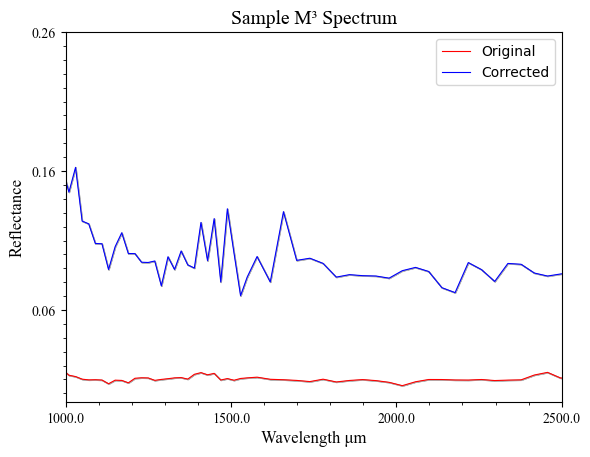

In [12]:
import spec_plotting
import spectral as sp
import matplotlib.pyplot as plt
import numpy as np
hdr = sp.envi.open(r'E:\Data\20230209T095534013597\extracted_files\hdr_files\m3g20090417t193320_v01_rfl\m3g20090417t193320_v01_rfl.hdr')
wvl = np.array(hdr.bands.centers)
allowedIndices = np.where((wvl>900)&(wvl<2600))
allowedWvl = wvl[allowedIndices]
img_smooth = np.load(r'E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20\Smooth_Spectrum_Image.npy')
img_corrected = np.load(r'E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20\Correced_Image.npy')
img_original = np.load(r'E:\Data\Locate_Ice_Saves\2009-04-17_19-33-20\Original_Image.npy')

print (allowedWvl)
print ((2576.96-910.14)/(len(allowedWvl)/5))
print (len(allowedWvl))
print ()

def plot(x,y):
    fig,ax = plt.subplots(1,1)
    spec_plotting.fancy_spec_plot(fig,ax,allowedWvl,img_original[x,y],label='Original',line_color='red',title='Sample M\u00B3 Spectrum')
    spec_plotting.fancy_spec_plot(fig,ax,allowedWvl,img_corrected[x,y],label='Corrected',line_color='blue')
    #spec_plotting.fancy_spec_plot(fig,ax,allowedWvl,img_smooth[x,y,:],label='Cubic Spline Fit',title='Sample M\u00B3 Spectrum')
    #plt.ylim(0.07,0.18)
    plt.savefig(r'E:/Data/Figures/Noisy M3 Spectrum')

plot(19,300)


In [44]:
import numpy as np
import warnings
def get_nmin(arr,nmin):
    arr_nozeros = arr[np.where(arr!=0)]
    part_nozeros = arr_nozeros[np.argpartition(arr_nozeros,nmin-1)][0:nmin]
    part = arr.flatten()[np.argpartition(arr.flatten(),nmin-1)][0:nmin]
    where = [(np.where(arr==i)[0],np.where(arr==i)[1]) for i in part_nozeros]
    where_formatted = []
    for i in where:
        for x,y in zip(i[0],i[1]):
            if (x,y) not in where_formatted and len(where_formatted)<nmin:
                where_formatted.append((x,y))
            elif len(where_formatted)==nmin:
                warnings.warn('There were more repeating minima than nmin! Increase nmin or exclude zeros...')
    where_formatted = np.array(where_formatted)

    return where_formatted[:,0],where_formatted[:,1]

arr = np.random.choice(range(0,20),(1017,314))

print (arr)
x,y = get_nmin(arr,20)
print ([(x,y) for x,y in zip(x,y)])
print (arr[x,y])

[[ 9  9 10 ... 13 11 11]
 [11  7 19 ... 14  2  5]
 [ 8 10 16 ...  3  5 12]
 ...
 [16 10 10 ...  9  3  4]
 [14 17  7 ...  8 19  4]
 [ 6  6  2 ... 11  1 14]]


C:\Users\zvig\AppData\Local\Temp\ipykernel_14012\3332237538.py:14: UserWarning: There were more repeating minima than nmin! Increase nmin or exclude zeros...
  warnings.warn('There were more repeating minima than nmin! Increase nmin or exclude zeros...')


[(0, 9), (0, 18), (0, 24), (0, 47), (0, 65), (0, 67), (0, 112), (0, 120), (0, 136), (0, 155), (0, 163), (0, 174), (0, 175), (0, 190), (0, 192), (0, 208), (0, 216), (0, 230), (0, 244), (0, 261)]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
from tkinter.filedialog import askdirectory as askdir
import datetime

print (datetime.datetime.now())

2023-04-13 16:45:35.283271
